<h4> Notebook to do the linear modelling of the extracted features and the the wealth index data. Also compares to baseline model just using nightlight

In [17]:
import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model 
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.model_selection import train_test_split
import torch
import xgboost as xg

Various functions used to create the linear models and plot them

In [344]:
def svr(X_train, y_train, X_test):
    model = SVR(C=1.0, epsilon=0.2)
    model.fit(X_train, y_train)
    output = model.predict(X_test)
    return output

def best_est(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train, X_test = scaler(X_train, X_test)
    alpha_values = np.arange(1, 10)
    bestR2 = -10000
    best_alpha = 0
    for val in alpha_values:
        model = RandomForestRegressor(n_estimators=val)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        r2 = metrics.r2_score(y_test, y_preds)
        if r2 > bestR2:
            bestR2 = r2
            best_alpha = val
    return best_alpha

def best_alpha_svr(X, y):

    """ 
    Function that returns the best alpha value for a given data sets. This is a regularization parameter used for ridge regression.
        :param X: Input to model
        :param y: Ground truth labels
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train, X_test = scaler(X_train, X_test)
    alpha_values = np.logspace(-2, 2)
    bestR2 = -10000
    best_alpha = 0
    for val in alpha_values:
        model = SVR(C=val, epsilon=0.2)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        r2 = metrics.r2_score(y_test, y_preds)
        if r2 > bestR2:
            bestR2 = r2
            best_alpha = val
    return best_alpha

def best_epsilon(X, y):

    """ 
    Function that returns the best alpha value for a given data sets. This is a regularization parameter used for ridge regression.
        :param X: Input to model
        :param y: Ground truth labels
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    X_train, X_test = scaler(X_train, X_test)
    epsilon_values = np.logspace(-2, 2)
    bestR2 = -10000
    best_epsilon = 0
    for val in epsilon_values:
        model = SVR(C=100, epsilon=val)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        r2 = metrics.r2_score(y_test, y_preds)
        if r2 > bestR2:
            bestR2 = r2
            best_epsilon = val
    return best_epsilon


def scaler(X_train, X_test):
    """
    Scales the data using standard scaler
        :param X_train: Training data
        :param X_test Testing data
    """
    scl = StandardScaler(with_mean=True, with_std=False)
    X_train = scl.fit_transform(X_train)
    X_test = scl.transform(X_test)
    return X_train, X_test

def kfold(X, y, splits = 5):

    """ 
        Function performs k fold cross validation and returns the R2 values, as well as the true and predicted values for each fold

        :param X: Input to model
        :param y: Ground truth labels
        :param alpha: Regularization parameter
        :param splits: Number of splits in the k fold
    """
    y_pred_list = []
    y_true = []
    r2s = []
    maes = []
    kf = KFold(splits)
    data = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test = scaler(X_train, X_test)
        data.append(y_test)
        alpha = best_alpha(X_train, X_test, y_train, y_test)
        model = linear_model.Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        mae = metrics.mean_absolute_error(y_test, y_preds)
        r2 = metrics.r2_score(y_test, y_preds)
        r2s.append(r2)
        maes.append(mae)
        y_pred_list.append(y_preds)
        y_true.append(y_test)

    return r2s, maes, y_pred_list, y_true, data

def best_alpha(X_train, X_test, y_train, y_test):

    """ 
    Function that returns the best alpha value for a given data sets. This is a regularization parameter used for ridge regression.
        :param X: Input to model
        :param y: Ground truth labels
    """

    X_train, X_test = scaler(X_train, X_test)
    alpha_values = np.logspace(-2, 2)
    bestR2 = -10000
    best_alpha = 0
    for val in alpha_values:
        model = linear_model.Ridge(alpha=val)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        r2 = metrics.r2_score(y_test, y_preds)
        if r2 > bestR2:
            bestR2 = r2
            best_alpha = val
    return best_alpha

def plot_predictions(y_test, y_preds, title):
    """ 
    Plots the predictions against the true

        :param y_test: Ground truth labels
        :param y_preds: Predicted values
        :param r2: R2 score
        :param title: Title of graph
    """
    plt.scatter(y_test, y_preds, color='black')
    plt.title(title)
    plt.plot(np.unique(y_preds), np.poly1d(np.polyfit(y_preds, y_test, 1))(np.unique(y_preds)), color='red')
    plt.xlabel('True Wealth Index')
    plt.ylabel('Predicted Wealth Index')


def aggregated_features_model(path):
    """ 
        Aggregates all the features for each cluster and retuns an NP array of aggregated the aggregated features that will 
        be used to train a linear model

        :param path: Path to saved aggregated features
    """

    aggregated_features = {}
    for i in sorted(os.listdir(path), key= lambda x: int(x)):
        for j in os.listdir(os.path.join(path, i)):
            aggregated_features[int(i)] = torch.load(os.path.join(path, i,j))
    X = list(aggregated_features.values())
    X = np.array([np.array(i) for i in X])
    assert (X[0] == np.array(aggregated_features[1])).all()
    return X    

Load the cluster data for labels for the linear model

In [19]:
cluster_data = pd.read_csv('clusters_with_nightlights_2017.csv')
y = np.array(list(cluster_data['Wealth index factor score combined (5 decimals)']))

Nightlight data to be used to train a linear model as a baseline

In [21]:
X_nightlights = np.array(list(cluster_data['Average Nightlight'])).reshape(-1, 1)

Aggregated features for each model

In [75]:
X_vit = aggregated_features_model('cluster_features_vit_ban')
X_resnet = aggregated_features_model('cluster_features_resnet_ban')
X_vgg = aggregated_features_model('cluster_features_vgg_ban')
X_swin = aggregated_features_model('cluster_features_swin_ban')
X_efficient = aggregated_features_model('cluster_features_efficientnet_ban')

X_train, X_test, y_train, y_test = train_test_split(X_vit, y, test_size=0.25, random_state=42)
vit_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X_resnet, y, test_size=0.25, random_state=42)
resnet_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X_vgg, y, test_size=0.25, random_state=42)
vgg_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X_swin, y, test_size=0.25, random_state=42)
swin_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X_efficient, y, test_size=0.25, random_state=42)
efficient_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X_efficient, y, test_size=0.25, random_state=42)
nightlights_best_alpha = best_alpha(X_train, X_test, y_train, y_test)

In [262]:
def kfold_average(la):
    x = []
    for j in range(len(la[0])):
        d = []
        for i in la:
            d.append(i[j])
        x.append(np.mean(d, axis=0))
    return x


Five Fold cross validation for each model

In [346]:
r2s_vit, maes_vit, predicted_vit, true_vit, data = kfold(X_vit, y)
r2s_resnet, maes_resnet, predicted_resnet, true_vit, data = kfold(X_resnet, y)
r2s_vgg, maes_vgg, predicted_vgg, true_vit, data = kfold(X_vgg, y)
r2s_swin, maes_swin, predicted_swin, true_swin, data = kfold(X_swin, y)
r2s_efficient, maes_efficient, predicted_efficient, true_efficient, data = kfold(X_efficient, y)
r2s_nightlights, maes_nightlights, predicted_nightlights, true_nightlights, data = kfold(X_nightlights, y)

c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
models = []

In [128]:
preds_dict = {}
r2_dict = {}
mae_dict = {}
alpha_dict = {'vgg': vgg_best_alpha, 'vit': vit_best_alpha, 'resnet':resnet_best_alpha, 'efficient': efficient_best_alpha, 'swin':swin_best_alpha}
names = ['vgg', 'vit', 'resnet', 'efficient', 'swin']
for idx, i in enumerate([X_vgg, X_vit, X_resnet, X_efficient, X_swin]):
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.25, random_state=42)
    model = linear_model.Ridge(alpha=alpha_dict[names[idx]])
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    preds_dict[names[idx]] = y_preds
    r2_dict[names[idx]] = metrics.r2_score(y_test, y_preds)
    mae_dict[names[idx]] = metrics.mean_absolute_error(y_test, y_preds)

_, _, _, y_test = train_test_split(X_vit, y, test_size=0.25, random_state=42)

{'vgg': 0.6445820726043752, 'vit': 0.6185954447108091, 'resnet': 0.6512705256509688, 'efficient': 0.6404464502901783, 'swin': 0.6440005931014807}
{'vgg': 36.18974965240842, 'vit': 37.39301136007763, 'resnet': 36.06304160944621, 'efficient': 35.91966297658285, 'swin': 36.631501434961955}


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_vgg, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=vgg_best_alpha)
model.fit(X_train, y_train)
y_preds_vgg = model.predict(X_test)
r2 = np.mean(r2s_vgg)
r2 = metrics.r2_score(y_test, y_preds_vgg)
mae = metrics.mean_absolute_error(y_test, y_preds_vgg)

X_train, X_test, y_train, y_test = train_test_split(X_resnet, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=resnet_best_alpha)
model.fit(X_train, y_train)
y_preds_resnet = model.predict(X_test)
r2 = metrics.r2_score(y_test, y_preds_resnet)
mae = metrics.mean_absolute_error(y_test, y_preds_resnet)
X_train, X_test, y_train, y_test = train_test_split(X_swin, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=swin_best_alpha)
model.fit(X_train, y_train)
y_preds_swin = model.predict(X_test)
r2 = metrics.r2_score(y_test, y_preds_swin)
mae = metrics.mean_absolute_error(y_test, y_preds_swin)

X_train, X_test, y_train, y_test = train_test_split(X_efficient, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=efficient_best_alpha)
model.fit(X_train, y_train)
y_preds_efficient = model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_preds_efficient)
r2 = metrics.r2_score(y_test, y_preds_efficient)

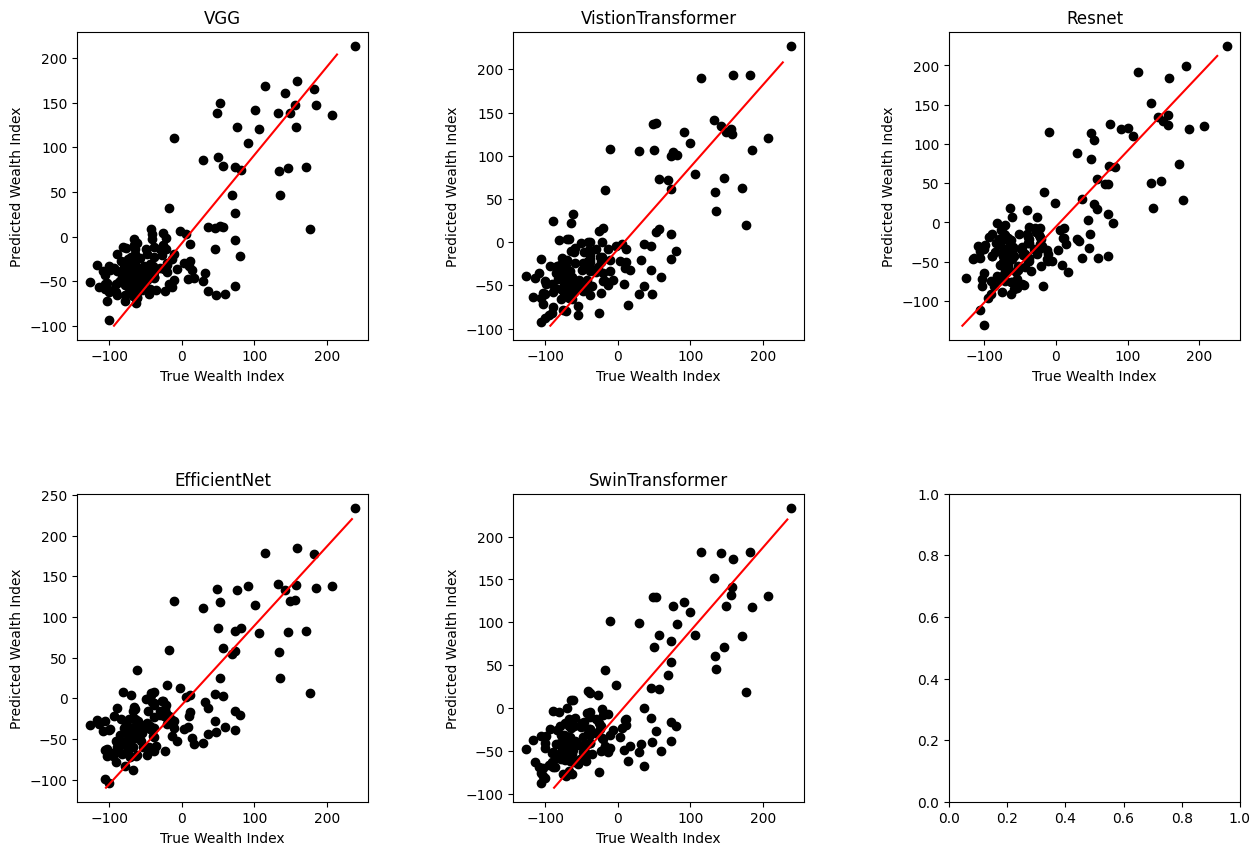

In [127]:

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5) 
titles = [['VGG', 'VistionTransformer', 'Resnet'], ['EfficientNet', 'SwinTransformer']]
for i in range(len(preds)):
    for j in range(len(preds[i])):
        ax[i][j].scatter(y_test, preds[i][j][1], color='black')
        ax[i][j].set_title(titles[i][j])
        ax[i][j].plot(np.unique(preds[i][j][1]), np.poly1d(np.polyfit(preds[i][j][1], y_test, 1))(np.unique(preds[i][j][1])), color='red')
        ax[i][j].set_xlabel('True Wealth Index')
        ax[i][j].set_ylabel('Predicted Wealth Index')

0.6445825979969024
36.1897622006053


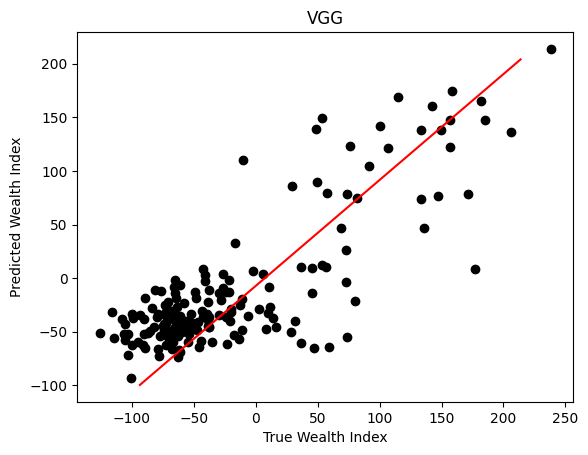

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_vgg, y, test_size=0.25, random_state=42)
X_train, X_test = scaler(X_train, X_test)
model = linear_model.Ridge(alpha=vgg_best_alpha)
model.fit(X_train, y_train)
y_preds_vgg = model.predict(X_test)
r2 = np.mean(r2s_vgg)
r2 = metrics.r2_score(y_test, y_preds_vgg)
mae = metrics.mean_absolute_error(y_test, y_preds_vgg)
plot_predictions(y_test, y_preds_vgg,  'VGG')
print(r2)
print(mae)

0.6512705256509688
36.06304160944621


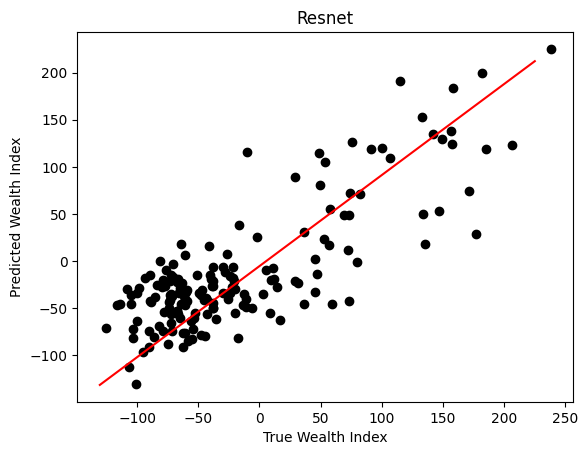

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_resnet, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=resnet_best_alpha)
model.fit(X_train, y_train)
y_preds_resnet = model.predict(X_test)
r2 = metrics.r2_score(y_test, y_preds_resnet)
mae = metrics.mean_absolute_error(y_test, y_preds_resnet)
print(r2)
print(mae)
plot_predictions(y_test, y_preds_resnet, 'Resnet')

0.6440005931014807
36.631501434961955


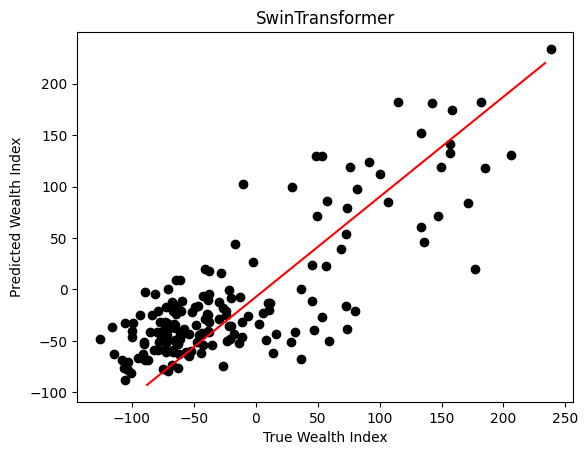

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_swin, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=swin_best_alpha)
model.fit(X_train, y_train)
y_preds_swin = model.predict(X_test)
r2 = metrics.r2_score(y_test, y_preds_swin)
mae = metrics.mean_absolute_error(y_test, y_preds_swin)
print(r2)
print(mae)
plot_predictions(y_test, y_preds_swin, 'SwinTransformer')

0.6404464502901783
35.91966297658285


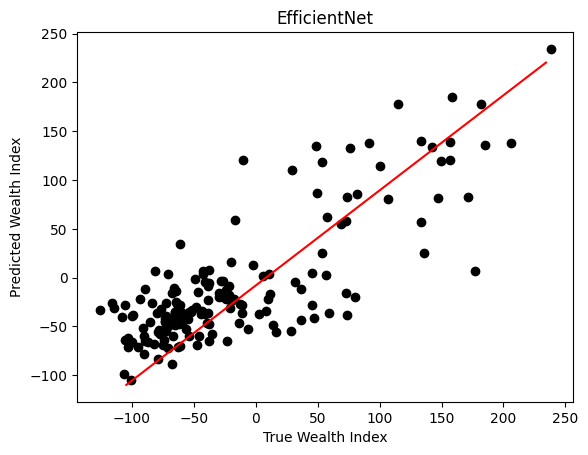

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_efficient, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=efficient_best_alpha)
model.fit(X_train, y_train)
y_preds_efficient = model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_preds_efficient)
r2 = metrics.r2_score(y_test, y_preds_efficient)
print(r2)
print(mae)
plot_predictions(y_test, y_preds_efficient, 'EfficientNet')

Here is the baseline that only uses nightlights to train the linear model. The vision transfomer model is certainly superior with a higher R2 value.

0.3969015057606705
46.824720163796655


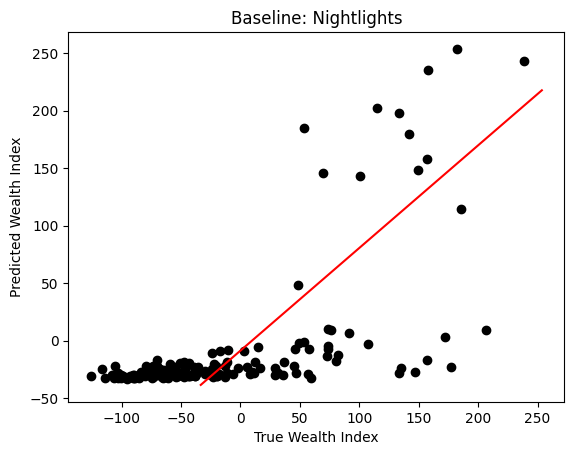

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_nightlights, y, test_size=0.25, random_state=42)
model = linear_model.Ridge(alpha=nightlights_best_alpha)
model.fit(X_train, y_train)
y_preds_nightlights = model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_preds_nightlights)
r2 = metrics.r2_score(y_test, y_preds_nightlights)
print(r2)
print(mae)
plot_predictions(y_test, y_preds_nightlights, 'Baseline: Nightlights')

In [357]:
models_dict = {'vgg': (X_vgg, vgg_best_alpha), 'vit': (X_vit, vit_best_alpha), 'resnet': (X_resnet, resnet_best_alpha), 'efficient': (X_efficient, efficient_best_alpha), 'swin': (X_swin, swin_best_alpha)}

kfold_r2s = []
kfold_maes = []

choose2 = list(combinations(models_dict.keys(), 2))
choose3 = list(combinations(models_dict.keys(), 3))
choose4 = list(combinations(models_dict.keys(), 4))
choose5 = list(combinations(models_dict.keys(), 5))

choose2_kfold = []
choose3_kfold = []
choose4_kfold = []
choose5_kfold = []

choose2_list = []
choose3_list = []
choose4_list = []
choose5_list = []


for i in choose2:    
    current = []
    tests = []
    folds = []
    for model in i:
        X_train, X_test, y_train, y_test = train_test_split(models_dict[model][0], y, test_size=0.25, random_state=42)
        r2s_choose2, maes_choose2, predicted_choose2, true_choose2, data = kfold(models_dict[model][0], y)
        folds.append(predicted_choose2)
        model = linear_model.Ridge(alpha=models_dict[model][1])
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        current.append(y_preds)
        tests.append(y_test)
    kfold_preds = kfold_average(folds)
    preds = sum(current)/len(current)
    choose2_kfold.append((i, kfold_preds, true_choose2))
    choose2_list.append((i, preds, y_test))

for i in choose3:    
    current = []
    tests = []
    for model in i:
        X_train, X_test, y_train, y_test = train_test_split(models_dict[model][0], y, test_size=0.25, random_state=42)
        r2s_choose3, maes_choose3, predicted_choose3, true_choose3, data = kfold(models_dict[model][0], y)
        folds.append(predicted_choose3)
        model = linear_model.Ridge(alpha=models_dict[model][1])
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        current.append(y_preds)
        tests.append(y_test)
    kfold_preds = kfold_average(folds)
    preds = sum(current)/len(current)
    choose3_kfold.append((i, kfold_preds, true_choose3))
    choose3_list.append((i, preds, y_test))

for i in choose4:    
    current = []
    tests = []
    for model in i:
        X_train, X_test, y_train, y_test = train_test_split(models_dict[model][0], y, test_size=0.25, random_state=42)
        r2s_choose4, maes_choose4, predicted_choose4, true_choose4, data = kfold(models_dict[model][0], y)
        folds.append(predicted_choose4)
        model = linear_model.Ridge(alpha=models_dict[model][1])
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        current.append(y_preds)
        tests.append(y_test)
    kfold_preds = kfold_average(folds)
    preds = sum(current)/len(current)
    choose4_kfold.append((i, kfold_preds, true_choose4))
    choose4_list.append((i, preds, y_test))

for i in choose5:    
    current = []
    tests = []
    for model in i:
        X_train, X_test, y_train, y_test = train_test_split(models_dict[model][0], y, test_size=0.25, random_state=42)
        r2s_choose5, maes_choose5, predicted_choose5, true_choose5, data = kfold(models_dict[model][0], y)
        folds.append(predicted_choose5)
        model = linear_model.Ridge(alpha=models_dict[model][1])
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        current.append(y_preds)
        tests.append(y_test)
    kfold_preds = kfold_average(folds)
    preds = sum(current)/len(current)
    choose5_kfold.append((i, kfold_preds, true_choose5))
    choose5_list.append((i, preds, y_test))

c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.57284e-08)

In [331]:
print(len(choose2_kfold[0][2]))

134


In [82]:
choose_dict_r2 = {}
choose_dict_mae = {}


all_list = choose2_list + choose3_list + choose4_list + choose5_list

for i in all_list:
    choose_dict_r2[i[0]] = metrics.r2_score(i[2], i[1])
    choose_dict_mae[i[0]] = metrics.mean_absolute_error(i[2], i[1])


In [379]:
choose_dict_r2

{('vgg', 'vit'): 0.6502966629591357,
 ('vgg', 'resnet'): 0.664994147388047,
 ('vgg', 'efficient'): 0.654989988550126,
 ('vgg', 'swin'): 0.6574340621245829,
 ('vit', 'resnet'): 0.6495743215479426,
 ('vit', 'efficient'): 0.641573440382351,
 ('vit', 'swin'): 0.6419133247403788,
 ('resnet', 'efficient'): 0.6616570883249799,
 ('resnet', 'swin'): 0.6628387094757172,
 ('efficient', 'swin'): 0.653778681495597,
 ('vgg', 'vit', 'resnet'): 0.6605569418346254,
 ('vgg', 'vit', 'efficient'): 0.6537573762649538,
 ('vgg', 'vit', 'swin'): 0.6545997880588732,
 ('vgg', 'resnet', 'efficient'): 0.6655850960935363,
 ('vgg', 'resnet', 'swin'): 0.6668016113627926,
 ('vgg', 'efficient', 'swin'): 0.6595313117622605,
 ('vit', 'resnet', 'efficient'): 0.6556563342367816,
 ('vit', 'resnet', 'swin'): 0.6559376478688166,
 ('vit', 'efficient', 'swin'): 0.6495576952562367,
 ('resnet', 'efficient', 'swin'): 0.6641533707666353,
 ('vgg', 'vit', 'resnet', 'efficient'): 0.6614096018683611,
 ('vgg', 'vit', 'resnet', 'swin'):

In [380]:
choose_dict_mae

{('vgg', 'vit'): 35.74242879277184,
 ('vgg', 'resnet'): 35.11578240430923,
 ('vgg', 'efficient'): 35.485069374175296,
 ('vgg', 'swin'): 35.56324030603681,
 ('vit', 'resnet'): 35.87289267285665,
 ('vit', 'efficient'): 36.090763259478976,
 ('vit', 'swin'): 36.75722252959297,
 ('resnet', 'efficient'): 34.92446946679978,
 ('resnet', 'swin'): 35.48611994557153,
 ('efficient', 'swin'): 35.67669842520214,
 ('vgg', 'vit', 'resnet'): 35.11527023258663,
 ('vgg', 'vit', 'efficient'): 35.556220614467705,
 ('vgg', 'vit', 'swin'): 35.785585414181156,
 ('vgg', 'resnet', 'efficient'): 34.85928749461969,
 ('vgg', 'resnet', 'swin'): 35.013176327353435,
 ('vgg', 'efficient', 'swin'): 35.36995476871658,
 ('vit', 'resnet', 'efficient'): 35.37083268790302,
 ('vit', 'resnet', 'swin'): 35.71277357412946,
 ('vit', 'efficient', 'swin'): 36.001924134166465,
 ('resnet', 'efficient', 'swin'): 35.05204874878696,
 ('vgg', 'vit', 'resnet', 'efficient'): 35.07956968037287,
 ('vgg', 'vit', 'resnet', 'swin'): 35.2643540

In [62]:
reshaped = [[],[],[],[],[],[],[]]
for i in range(7):
    if i < 7:
        reshaped[i] = all_list[i+i*3:(i+i*3)+4]
    else:
        reshaped[i] = all_list[i+i*3:]
len(reshaped)

7

In [376]:
choose_dict_kfold_r2 = {}
choose_dict_kfold_mae = {}
all_list_kfold = choose2_kfold + choose3_kfold + choose4_kfold + choose5_kfold

for model in all_list_kfold:
    for idx in range(5):
        if not choose_dict_kfold_r2.get(model[0]):
            choose_dict_kfold_r2[model[0]] = [metrics.r2_score(model[2][idx], model[1][idx])]
            choose_dict_kfold_mae[model[0]] = [metrics.mean_absolute_error(model[2][idx], model[1][idx])]
        else:
            choose_dict_kfold_r2[model[0]].append(metrics.r2_score(model[2][idx], model[1][idx]))
            choose_dict_kfold_mae[model[0]].append(metrics.mean_absolute_error(model[2][idx], model[1][idx]))


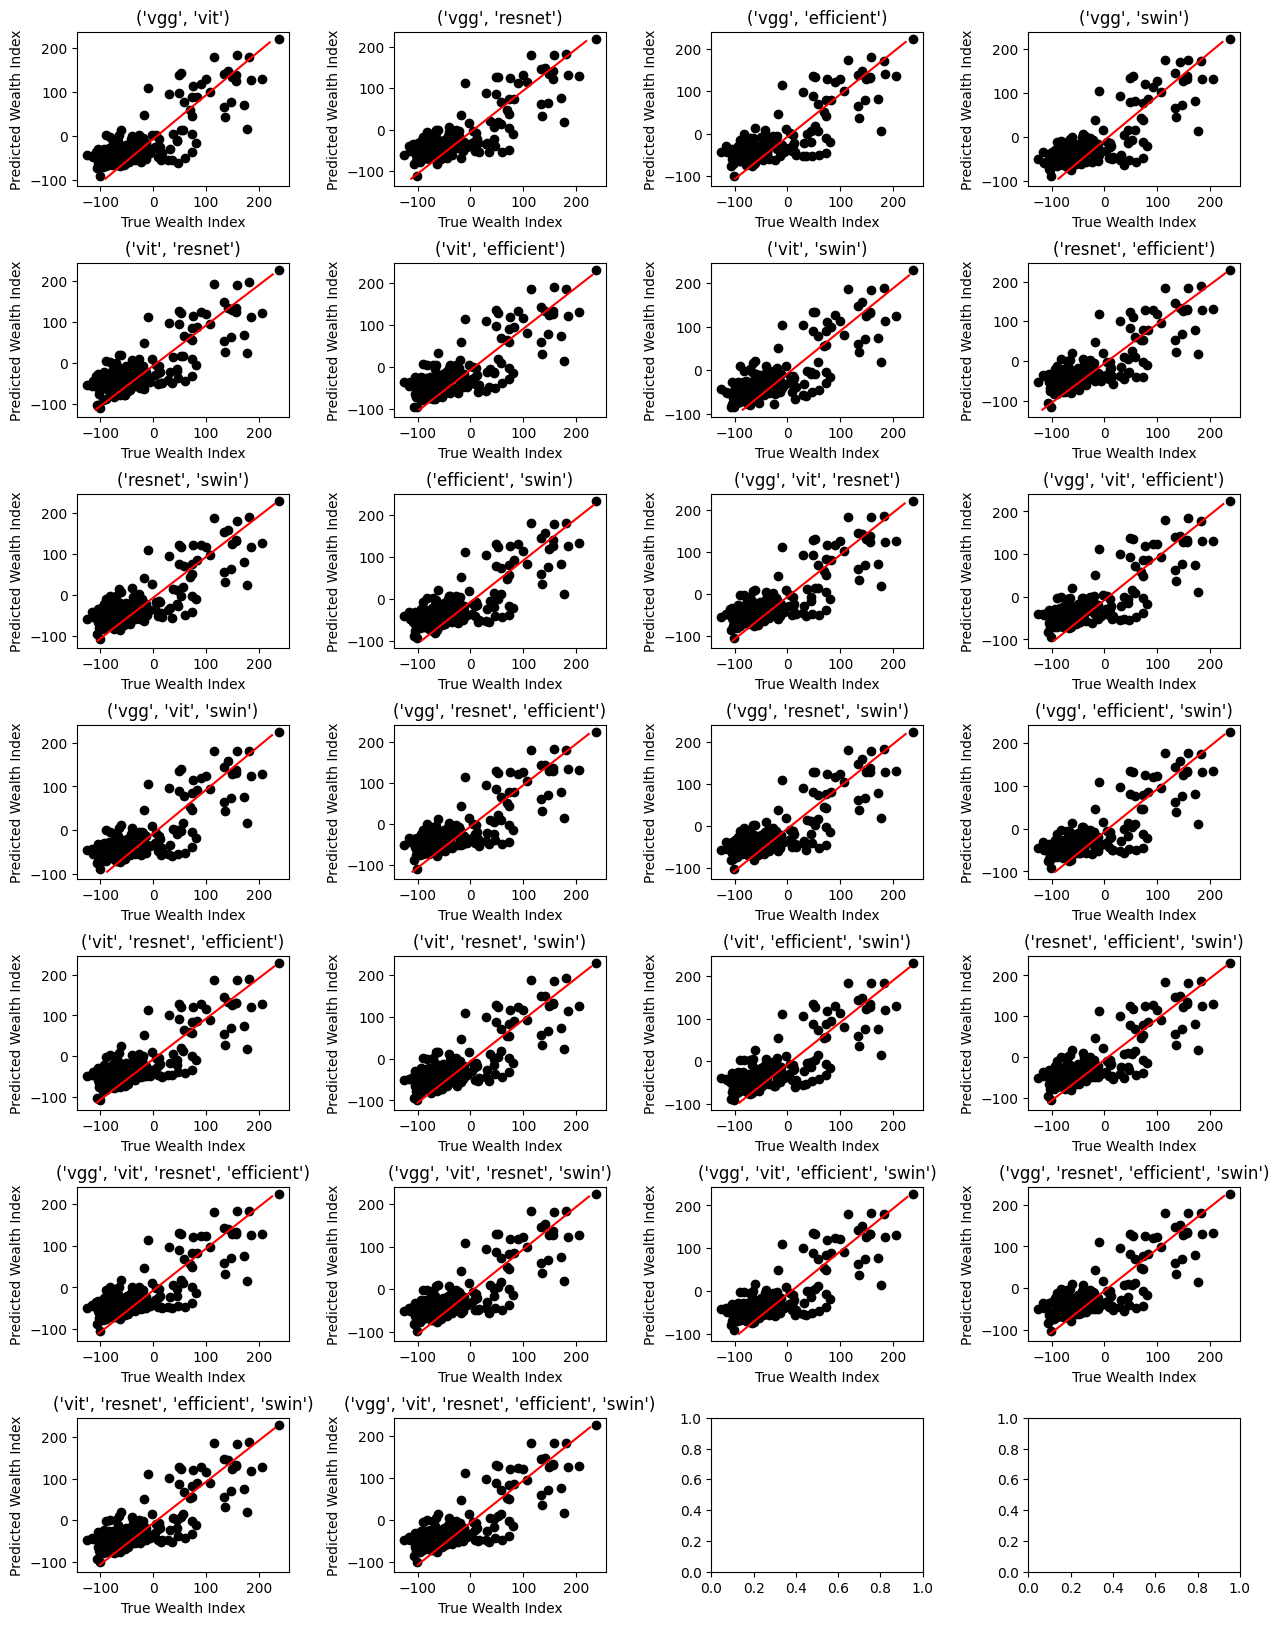

In [72]:
fig, ax = plt.subplots(7, 4, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5) 
for idx, j in enumerate(reshaped):
    for idx2, i in enumerate(reshaped[idx]):
        ax[idx][idx2].scatter(i[2], i[1], color='black')
        ax[idx][idx2].set_title(i[0])
        ax[idx][idx2].plot(np.unique(i[1]), np.poly1d(np.polyfit(i[1], i[2], 1))(np.unique(i[1])), color='r')
        ax[idx][idx2].set_xlabel('True Wealth Index')
        ax[idx][idx2].set_ylabel('Predicted Wealth Index')

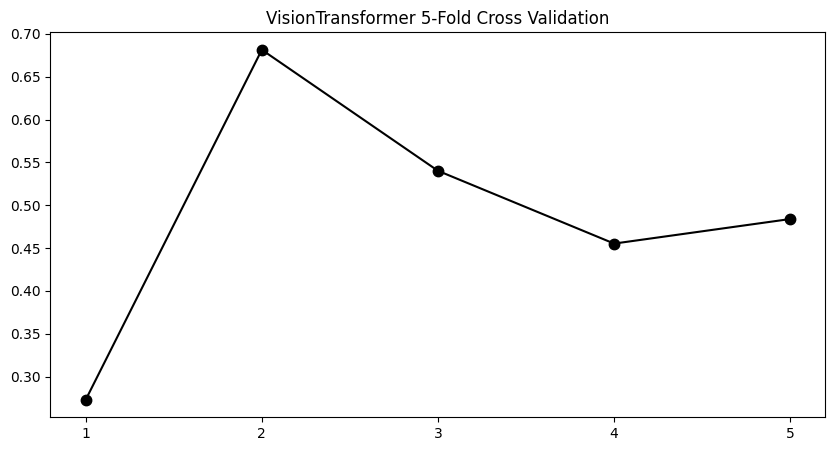

In [404]:
a = r2s_vit
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


ax.set_title('VisionTransformer 5-Fold Cross Validation')
ax.set_xticks([1,2,3,4,5])
ax.plot([1,2,3,4,5], a, color='black', marker='.', markersize=15)

In [424]:
r2s_efficient

[0.2662316812859158,
 0.6395914767247949,
 0.4987729817916954,
 0.4573522097218118,
 0.4963231702535731]

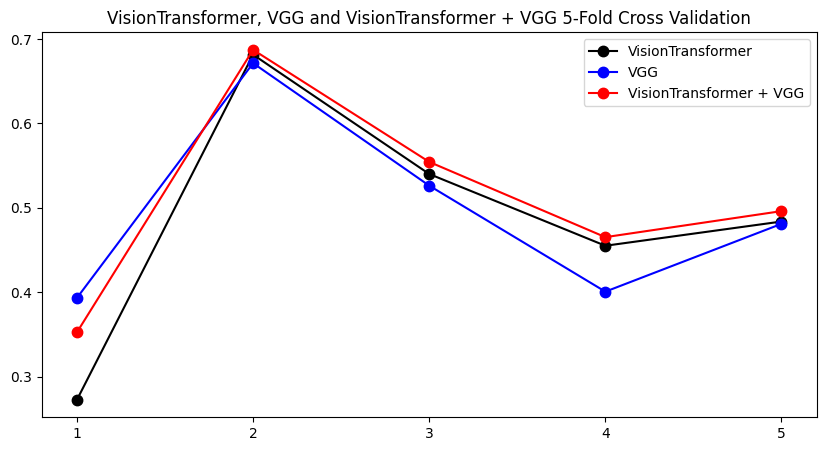

In [429]:
a = r2s_vit
c = r2s_vgg
b = choose_dict_kfold_r2[('vgg', 'vit')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


ax.set_title('VisionTransformer, VGG and VisionTransformer + VGG 5-Fold Cross Validation')
ax.set_xticks([1,2,3,4,5])
ax.plot([1,2,3,4,5], a, color='black', marker='.', markersize=15, label = 'VisionTransformer')
ax.plot([1,2,3,4,5], c, color='blue', marker='.', markersize=15, label='VGG')
ax.plot([1,2,3,4,5], b, color='red', marker='.', markersize=15, label='VisionTransformer + VGG')
ax.legend()

[Text(0, 0, "('vgg', 'vit')"),
 Text(1, 0, "('vgg', 'resnet')"),
 Text(2, 0, "('vgg', 'efficient')"),
 Text(3, 0, "('vgg', 'swin')"),
 Text(4, 0, "('vit', 'resnet')"),
 Text(5, 0, "('vit', 'efficient')"),
 Text(6, 0, "('vit', 'swin')"),
 Text(7, 0, "('resnet', 'efficient')"),
 Text(8, 0, "('resnet', 'swin')"),
 Text(9, 0, "('efficient', 'swin')"),
 Text(10, 0, "('vgg', 'vit', 'resnet')"),
 Text(11, 0, "('vgg', 'vit', 'efficient')"),
 Text(12, 0, "('vgg', 'vit', 'swin')"),
 Text(13, 0, "('vgg', 'resnet', 'efficient')"),
 Text(14, 0, "('vgg', 'resnet', 'swin')"),
 Text(15, 0, "('vgg', 'efficient', 'swin')"),
 Text(16, 0, "('vit', 'resnet', 'efficient')"),
 Text(17, 0, "('vit', 'resnet', 'swin')"),
 Text(18, 0, "('vit', 'efficient', 'swin')"),
 Text(19, 0, "('resnet', 'efficient', 'swin')"),
 Text(20, 0, "('vgg', 'vit', 'resnet', 'efficient')"),
 Text(21, 0, "('vgg', 'vit', 'resnet', 'swin')"),
 Text(22, 0, "('vgg', 'vit', 'efficient', 'swin')"),
 Text(23, 0, "('vgg', 'resnet', 'efficient

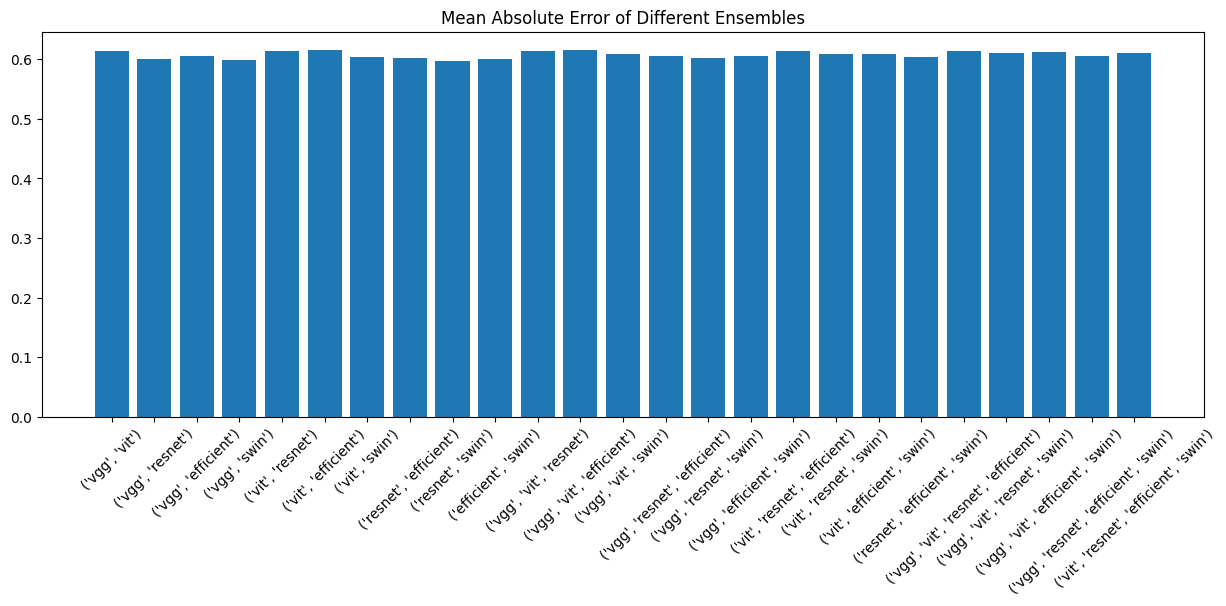

In [161]:
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(range(25), choose_dict_r2.values(), tick_label=choose_dict_r2.keys())
ax.set_title('Mean Absolute Error of Different Ensembles')
ax.set_xticklabels(choose_dict_r2.keys(), rotation = 45)# ax.set_xticks(ind + width / 2)

[Text(0, 0, "('vgg', 'vit')"),
 Text(1, 0, "('vgg', 'resnet')"),
 Text(2, 0, "('vgg', 'efficient')"),
 Text(3, 0, "('vgg', 'swin')"),
 Text(4, 0, "('vit', 'resnet')"),
 Text(5, 0, "('vit', 'efficient')"),
 Text(6, 0, "('vit', 'swin')"),
 Text(7, 0, "('resnet', 'efficient')"),
 Text(8, 0, "('resnet', 'swin')"),
 Text(9, 0, "('efficient', 'swin')"),
 Text(10, 0, "('vgg', 'vit', 'resnet')"),
 Text(11, 0, "('vgg', 'vit', 'efficient')"),
 Text(12, 0, "('vgg', 'vit', 'swin')"),
 Text(13, 0, "('vgg', 'resnet', 'efficient')"),
 Text(14, 0, "('vgg', 'resnet', 'swin')"),
 Text(15, 0, "('vgg', 'efficient', 'swin')"),
 Text(16, 0, "('vit', 'resnet', 'efficient')"),
 Text(17, 0, "('vit', 'resnet', 'swin')"),
 Text(18, 0, "('vit', 'efficient', 'swin')"),
 Text(19, 0, "('resnet', 'efficient', 'swin')"),
 Text(20, 0, "('vgg', 'vit', 'resnet', 'efficient')"),
 Text(21, 0, "('vgg', 'vit', 'resnet', 'swin')"),
 Text(22, 0, "('vgg', 'vit', 'efficient', 'swin')"),
 Text(23, 0, "('vgg', 'resnet', 'efficient

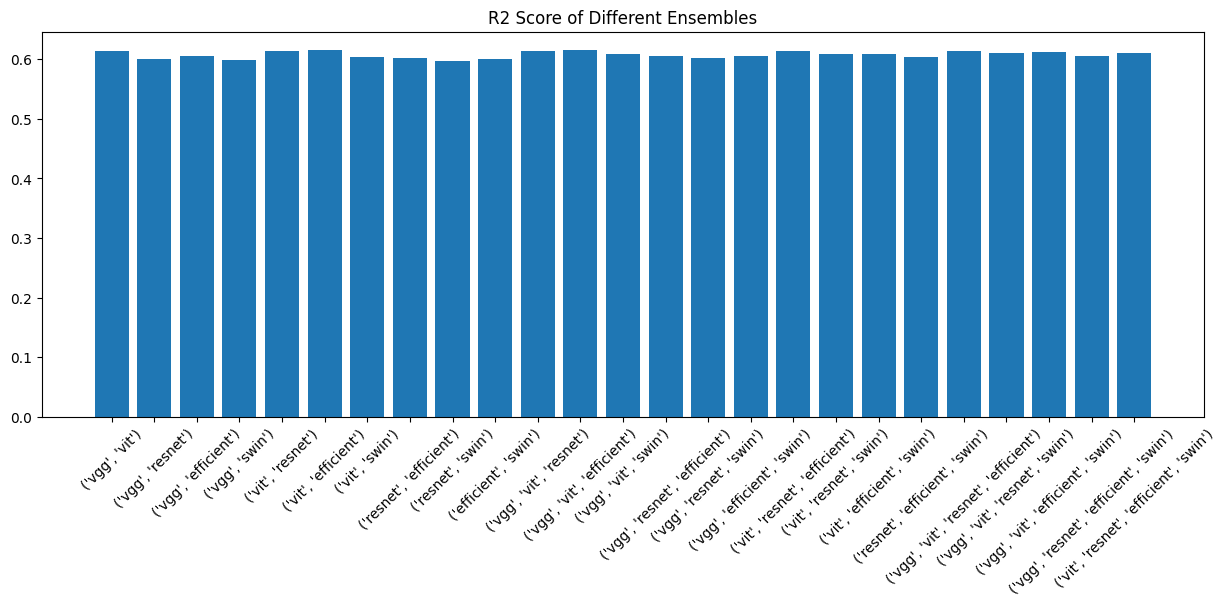

In [162]:
fig, ax = plt.subplots(figsize=(15,5))

a = ax.bar(range(25), choose_dict_r2.values(), tick_label=choose_dict_r2.keys())
ax.set_title('R2 Score of Different Ensembles')
ax.set_xticklabels(choose_dict_r2.keys(), rotation = 45)# ax.set_xticks(ind + width / 2)

